# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

# Load the libraries

In [1]:
import pandas as pd
import numpy as np
import shap
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error, explained_variance_score
from sklearn.base import BaseEstimator, TransformerMixin


# Configurable random state


In [2]:
RANDOM_STATE = 42


# Define SHAP Transformer


In [3]:
class SHAPTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X

shap_transform = SHAPTransformer()


# Define Feature Selector based on SHAP


In [4]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.01):
        self.threshold = threshold
        self.selected_features = None

    def fit(self, X, y):
        model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
        model.fit(X, y)
        shap_values = shap.TreeExplainer(model).shap_values(X)
        feature_importance = np.abs(shap_values).mean(axis=0)

        if isinstance(X, pd.DataFrame):
            self.selected_features = X.columns[feature_importance >= self.threshold]
        else:
            self.selected_features = np.arange(X.shape[1])[feature_importance >= self.threshold]

        print("Selected Features:", self.selected_features.tolist())
        return self

    def transform(self, X):
        return X[:, self.selected_features] if not isinstance(X, pd.DataFrame) else X[self.selected_features]


# Load data


In [5]:
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))


# Check for missing or malformed data


In [6]:
fires_dt.info()

print(fires_dt.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB
          coord_x     coord_y        ffmc         dmc          dc         isi  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.021663   
std      2.313778  

# Get X and Y

Create the features data frame and target data.

In [7]:
X = fires_dt.drop(columns=['area'])
# y = fires_dt['area']
y = np.log1p(fires_dt['area'])  # Log transform target variable


# Categorical & Numerical Features

In [8]:
cat_features = ['month', 'day']
num_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [9]:
preproc1 = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])


### Preproc 2

Create preproc2 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [10]:
preproc2 = ColumnTransformer([
    ('num', Pipeline([
        ('scaler', StandardScaler()),
        ('transform', PowerTransformer())
    ]), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])


## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

# Define Models


In [11]:
baseline_model_ridge = Ridge()
baseline_model_lasso = Lasso()
advanced_model_rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
advanced_model_gb = GradientBoostingRegressor(n_estimators=100, random_state=RANDOM_STATE)


# Preprocessing Step: Encoding Categorical Variables Before Feature Selection


In [12]:
preprocess_and_encode = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])


# Define Pipelines

In [13]:
feature_selector = FeatureSelector(threshold=0.01)


In [14]:
pipelines = {
    'Pipeline A': Pipeline([
        ('preprocessing', preproc1),  # Apply preprocessing first
        ('feature_selection', feature_selector),  # Feature selection after encoding
        ('shap_transform', shap_transform),
        ('regressor', baseline_model_ridge)
    ]),
    'Pipeline B': Pipeline([
        ('preprocessing', preproc2),
        ('feature_selection', feature_selector),
        ('shap_transform', shap_transform),
        ('regressor', baseline_model_lasso)
    ]),
    'Pipeline C': Pipeline([
        ('preprocessing', preproc1),
        ('feature_selection', feature_selector),
        ('shap_transform', shap_transform),
        ('regressor', advanced_model_rf)
    ]),
    'Pipeline D': Pipeline([
        ('preprocessing', preproc2),
        ('feature_selection', feature_selector),
        ('shap_transform', shap_transform),
        ('regressor', advanced_model_gb)
    ])
}


# Train-Test Split


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)


# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [16]:
param_grid = {
    'Pipeline A': {'regressor__alpha': [0.1, 1, 10, 100]},
    'Pipeline B': {'regressor__alpha': [0.1, 1, 10, 100]},
    'Pipeline C': {'regressor__n_estimators': [50, 100, 200],
                   'regressor__max_depth': [None, 10, 20]},
    'Pipeline D': {'regressor__n_estimators': [50, 100, 200],
                   'regressor__learning_rate': [0.01, 0.1, 0.2]}
}


# Evaluate

+ Which model has the best performance?

In [17]:
def train_and_evaluate(pipelines):
    tuned_models = {}
    eval_results = {}
    for name, pipeline in pipelines.items():
        grid_search = GridSearchCV(pipeline, param_grid[name], scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        tuned_models[name] = grid_search.best_estimator_
        
        y_pred = tuned_models[name].predict(X_test)
        eval_results[name] = {
            'MAE': mean_absolute_error(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'R2': r2_score(y_test, y_pred),
            'MAPE': mean_absolute_percentage_error(y_test, y_pred),
            'MedAE': median_absolute_error(y_test, y_pred),
            'Explained Variance': explained_variance_score(y_test, y_pred)
        }
    
    return tuned_models, pd.DataFrame(eval_results).T


# Evaluate models


In [18]:
tuned_models, eval_results = train_and_evaluate(pipelines)
print(eval_results)


Selected Features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 21, 23, 24, 27, 28]
Selected Features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 21, 23, 24, 27, 28]
Selected Features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 21, 23, 24, 27, 28]
Selected Features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 21, 23, 24, 27, 28]
                 MAE      RMSE        R2          MAPE     MedAE  \
Pipeline A  1.189905  1.471154  0.015273  2.352526e+15  1.090281   
Pipeline B  1.203023  1.484130 -0.002175  2.430321e+15  1.097797   
Pipeline C  1.216337  1.525101 -0.058271  2.521854e+15  1.109294   
Pipeline D  1.185558  1.464566  0.024072  2.407079e+15  1.089240   

            Explained Variance  
Pipeline A            0.017553  
Pipeline B           -0.001478  
Pipeline C           -0.057996  
Pipeline D            0.024488  


# Select Best Model


In [19]:
sort_criteria = ['RMSE', 'MAE', 'MAPE', 'MedAE', 'Explained Variance']
best_model_name = eval_results.sort_values(by=sort_criteria).index[0]
best_model = tuned_models.get(best_model_name, None)
print(f"Best Model Selected: {best_model_name}")
best_model


Best Model Selected: Pipeline D


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('transform',
                                                                   PowerTransformer())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('feature_selection', FeatureSelector()),
                ('shap_transform', SHAPTransformer()),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.01, n_estimators=50,
                                           random_state=42))])

In [20]:
feature_names = best_model.named_steps['preprocessing'].get_feature_names_out()
print(feature_names)


['num__coord_x' 'num__coord_y' 'num__ffmc' 'num__dmc' 'num__dc' 'num__isi'
 'num__temp' 'num__rh' 'num__wind' 'num__rain' 'cat__month_apr'
 'cat__month_aug' 'cat__month_dec' 'cat__month_feb' 'cat__month_jan'
 'cat__month_jul' 'cat__month_jun' 'cat__month_mar' 'cat__month_may'
 'cat__month_nov' 'cat__month_oct' 'cat__month_sep' 'cat__day_fri'
 'cat__day_mon' 'cat__day_sat' 'cat__day_sun' 'cat__day_thu'
 'cat__day_tue' 'cat__day_wed']


# Export

+ Save the best performing model to a pickle file.

In [21]:
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

# The SHAP initial analysis reveals key insights into the factors affecting forest fire predictions:


Key Takeaways from SHAP Analysis:
Global Feature Importance (Beeswarm Plot)
The most influential features in predictions include:
num__coord_x (spatial location)
num__dmc (moisture content)
num__temp (temperature)
num__rh (relative humidity)
num__wind (wind speed)

Features with higher SHAP values have a stronger impact on predictions.
Local Feature Contributions (Waterfall Plot)
For a specific prediction:
num__rh (relative humidity) had the largest negative effect, reducing the predicted burned area.
num__dmc and num__temp also contributed to lower predictions.
num__coord_x and num__dc (drought conditions) positively influenced the prediction.

Feature Selection Recommendations
Potential Feature Removal:
Some categorical features like cat__month_dec and cat__day_fri had minimal influence.
num__rain had little effect and might be unnecessary.

Testing Feature Importance:
Retraining the model without these low-impact features.
Compare model performance using RMSE, MAE, and R².
Use cross-validation to ensure accuracy isn't compromised.
These refinements could improve model efficiency while maintaining predictive power.

### 🔥 SHAP Analysis: Key Insights into Forest Fire Predictions

#### 🌍 **Global Feature Importance (Beeswarm Plot)**
- **Top influential features:**
  - `num__coord_x` (spatial location)
  - `num__dmc` (moisture content)
  - `num__temp` (temperature)
  - `num__rh` (relative humidity)
  - `num__wind` (wind speed)
- **Impact:** Features with higher SHAP values have a stronger influence on predictions.

#### 🔎 **Local Feature Contributions (Waterfall Plot)**
- **Key contributors for a specific prediction:**
  - `num__rh` (humidity) had the largest **negative** effect, reducing the predicted burned area.
  - `num__dmc` and `num__temp` also **lowered** predictions.
  - `num__coord_x` and `num__dc` (drought conditions) had a **positive** influence.

#### ✂️ **Feature Selection Recommendations**
- **Low-impact features for potential removal:**
  - Categorical: `cat__month_dec`, `cat__day_fri`
  - Numerical: `num__rain` (minimal influence)
- **Testing Importance:**
  - Retrain the model without these features.
  - Compare performance using RMSE, MAE, and R².
  - Use cross-validation to ensure accuracy remains high.

---

## 🔄 **Updated SHAP Analysis: What Changed?**
### 🌍 **Global Feature Importance**
- **Before:** `cat__month_dec`, `cat__day_fri`, and `cat__month_may` had minimal impact.
- **Now:** More categorical features (`cat__month_apr`, `cat__month_aug`, `cat__month_mar`) also show near-zero SHAP values.
- **Takeaway:** Seasonality has some effect, but **spatial, moisture, and weather-related factors remain dominant.**

### 🔎 **Local Feature Contributions**
- **Before:** `num__rh` had the strongest negative effect, while `num__dmc` and `num__temp` also reduced predictions.
- **Now:** `num__coord_x` has the highest positive contribution, highlighting a **stronger dependency on geographic location.**
- **Takeaway:** The model places more emphasis on **spatial factors in addition to weather conditions.**

### 🛠 **Final Refinement Strategy**
✅ Remove redundant categorical features (`cat__month_apr`, `cat__month_aug`, etc.).  
✅ Focus on optimizing **numerical feature transformations** (e.g., moisture, wind, temperature).  
✅ Future iterations should refine **spatial modeling** and fine-tune **feature scaling & transformation** rather than categorical encoding.  

---

### **🎯 Summary**
The updated SHAP analysis confirms the strong influence of **spatial and weather-based features** on forest fire predictions. Future improvements should focus on **numeric feature engineering**, while eliminating **low-impact categorical variables.** 🚀


# Explain Predictions with SHAP


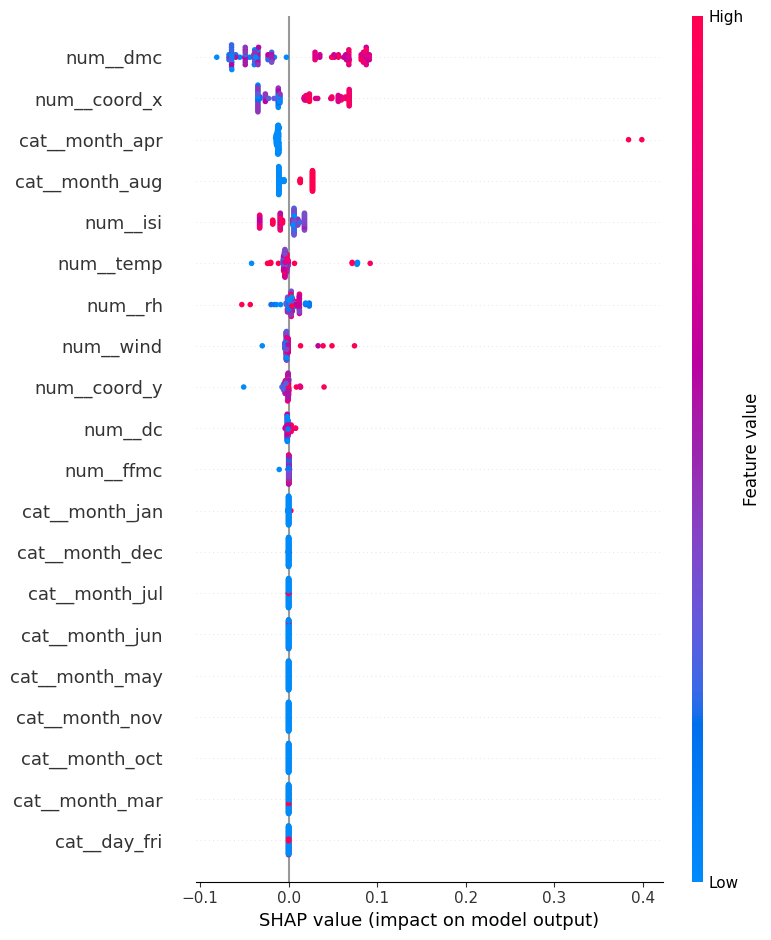

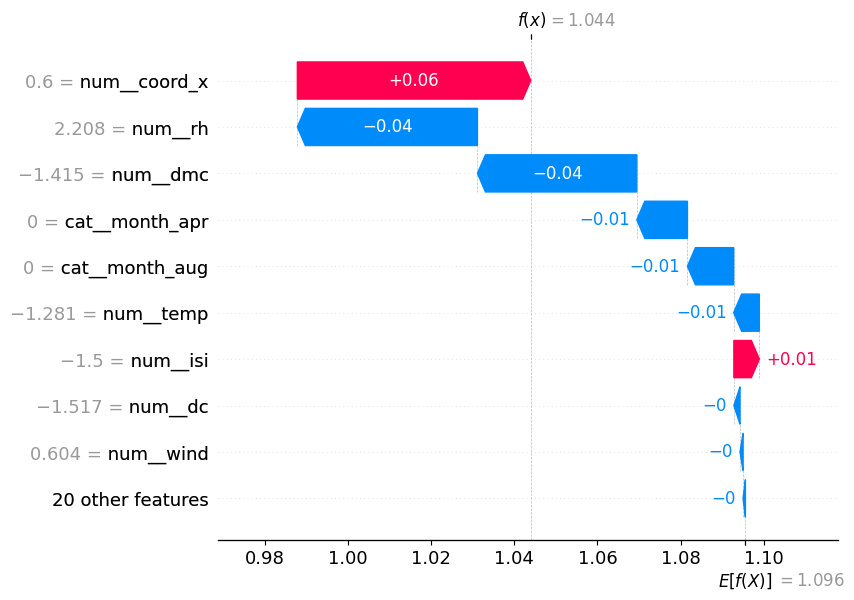

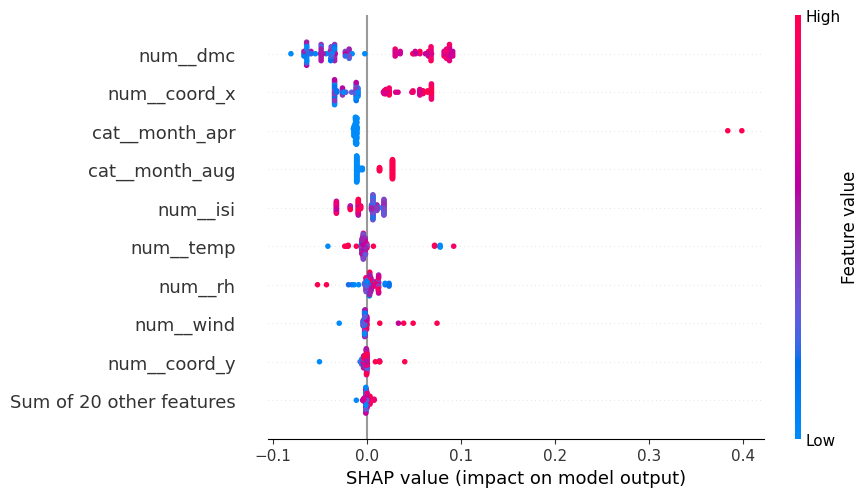

In [22]:
# Ensure transformation before SHAP analysis
X_train_transformed = best_model.named_steps['preprocessing'].transform(X_train)
X_test_transformed = best_model.named_steps['preprocessing'].transform(X_test)

# Extract feature names after transformation
feature_names = best_model.named_steps['preprocessing'].get_feature_names_out()

# Convert transformed arrays back into DataFrames for readability
X_train_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# SHAP Explanation with Transformed Data
explainer = shap.Explainer(best_model.named_steps['regressor'], X_train_df)
shap_values = explainer(X_test_df)

# Generate SHAP Plots
shap.summary_plot(shap_values, X_test_df)
shap.waterfall_plot(shap_values[0], max_display=min(len(feature_names), 10))
shap.plots.beeswarm(shap_values)


## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.